<a href="https://colab.research.google.com/github/KeertiBafna/Machine_Learning_Journey/blob/master/Human_Activity_Recognition_Keertish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
files.upload()

Saving test.csv to test.csv


KeyboardInterrupt: ignored

In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print('Training data has {} rows and {} columns'.format(df_train.shape[0], df_train.shape[1]))
print('Testing data has {} rows and {} columns'.format(df_test.shape[0], df_test.shape[1]))

Training data has 999 rows and 563 columns
Testing data has 999 rows and 563 columns


In [0]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [0]:
#The trends of the output
df_train.Activity.value_counts()

WALKING               209
STANDING              179
LAYING                164
WALKING_UPSTAIRS      159
WALKING_DOWNSTAIRS    145
SITTING               143
Name: Activity, dtype: int64

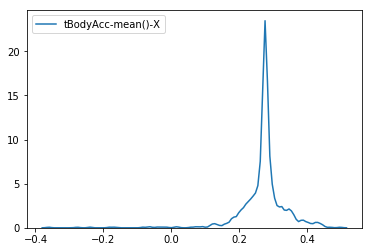

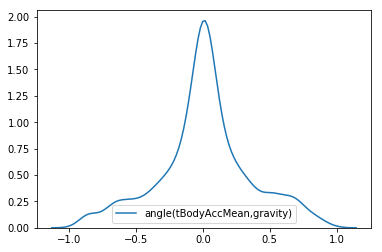

In [0]:
#Checking the distribution of 6 random features
plt.subplot(111)
sns.kdeplot(data=df_train['tBodyAcc-mean()-X'])
plt.show()
plt.subplot(111)
sns.kdeplot(data=df_train['angle(tBodyAccMean,gravity)'])
plt.show()

In [0]:
# from scipy.stats import zscore
# z = zscore(df_train)
# df_train_z = df_train[(z < 5).all(axis=1)]
# print(df_train_z.shape)
# X = df_train_z.drop('Activity',axis=1)
# y = df_train_z.Activity
# z1 = zscore(df_test)
# df_test_z = df_test[(z1 < 5).all(axis=1)]
# print(df_test_z.shape)
# X_test = df_test_z.drop('Activity',axis=1)
# y_test = df_test_z.Activity

In [0]:
#The features more or less look normally distributed. We will come back to this later,

In [0]:
#Checking missing data
print(df_train.isnull().any().sum())
print(df_test.isnull().any().sum())

#No missing data in either set

0
0


In [0]:
#Creating custom encoding for the output labels
all_labels = df_train.Activity.value_counts().index.tolist()
label_encoding = {val:index for index, val in enumerate(all_labels)}
print(label_encoding)

{'WALKING': 0, 'STANDING': 1, 'LAYING': 2, 'WALKING_UPSTAIRS': 3, 'WALKING_DOWNSTAIRS': 4, 'SITTING': 5}


In [0]:
#Dropping subject and encoding activities
df_train.drop('subject', axis='columns', inplace=True)

# Label encoding custom

for act in list(label_encoding.keys()):
    df_train.loc [ df_train.Activity == act , ['Activity']] = label_encoding[act]
df_train.Activity.value_counts()

0    209
1    179
2    164
3    159
4    145
5    143
Name: Activity, dtype: int64

In [0]:
#We will first use kFold to check the models with a good perofrmane. Later we will optimize for the best perofrming model
#defining functions for stratified kFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
def run_kfold (X, y, model,cv):
    sf = StratifiedKFold(n_splits=cv)
    prec_train_all, rec_train_all, f1_train_all = [], [], []
    prec_test_all, rec_test_all, f1_test_all = [], [], []
    for train_index, test_index in sf.split(X ,y):
        X_traincv, X_testcv = X.values[train_index] , X.values[test_index]
        y_traincv, y_testcv = y.values[train_index] , y.values[test_index]
        model.fit(X_traincv, y_traincv)
        ytrain_predcv = model.predict(X_traincv)
        ytest_predcv = model.predict(X_testcv)
        scores_train = precision_recall_fscore_support(y_traincv , ytrain_predcv)
        scores_test = precision_recall_fscore_support(y_testcv , ytest_predcv)
        prec_trian = scores_train[0] ; rec_train = scores_train[1] ; f1_train = scores_train[2]
        prec_test = scores_test[0] ; rec_test = scores_test[1] ; f1_test = scores_test[2]
        prec_train_all.append(prec_trian) ; rec_train_all.append(rec_train); f1_train_all.append(f1_train)
        prec_test_all.append(prec_test) ; rec_test_all.append(rec_test); f1_test_all.append(f1_test)
    #End for train_index
    train_prec_mean = np.average(prec_train_all, axis=0) ; train_rec_mean = np.average(rec_train_all, axis=0); train_f1_mean = np.average(f1_train_all, axis=0)
    test_prec_mean = np.average(prec_test_all, axis=0) ; test_rec_mean = np.average(rec_test_all, axis=0); test_f1_mean = np.average(f1_test_all, axis=0)
    return train_prec_mean, train_rec_mean, train_f1_mean, test_prec_mean, test_rec_mean, test_f1_mean
#End def run_kFold

In [0]:
#Separating the features and output
X = df_train.drop('Activity', axis=1)
y = df_train.Activity
print(X.shape)
print(y.shape)

(999, 561)
(999,)


In [0]:
#Initializing the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [0]:
lr  = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=10)
rf = RandomForestClassifier(max_depth=10)
models_all = {'LogisticRegression':lr, 'DecTree':dt, 'RanForest':rf}
cols = ['Activity','MeanPrec_Train','MeanPrec_Test','MeanRecal_Train','MeanRecal_Test','MeanF1_Train','MeanF1_Test','MODEL']
df_MVf = pd.DataFrame(columns=cols)
counter = 0
for indexer ,mod in enumerate(list(models_all.values())):
    train_pr, train_rec, train_f1, test_pr, test_rec, test_f1 = run_kfold(X, y, mod, 10)
    for labs in range(len(label_encoding)):
        list1 = [labs,train_pr[labs], test_pr[labs], train_rec[labs], test_rec[labs], train_f1[labs], test_f1[labs],list(models_all.keys())[indexer]]
        df_MVf.loc[counter] = list1
        counter += 1
    #End for labs
#End for indexer

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

In [0]:
# Decoding output

for decod in range(len(label_encoding)):
    df_MVf.loc [ df_MVf.Activity == decod , ['Activity']] = list(label_encoding.keys())[decod]
df_MVf

,Activity,MeanPrec_Train,MeanPrec_Test,MeanRecal_Train,MeanRecal_Test,MeanF1_Train,MeanF1_Test,MODEL
0,WALKING,1.000000,1.000000,1.000000,0.995000,1.000000,0.997436,LogisticRegression
1,STANDING,1.000000,0.953784,1.000000,0.988235,1.000000,0.970056,LogisticRegression
2,LAYING,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,LogisticRegression
3,WALKING_UPSTAIRS,1.000000,0.994118,1.000000,1.000000,1.000000,0.996970,LogisticRegression
4,WALKING_DOWNSTAIRS,1.000000,0.993333,1.000000,1.000000,1.000000,0.996552,LogisticRegression
5,SITTING,1.000000,0.984615,1.000000,0.928571,1.000000,0.954382,LogisticRegression
6,WALKING,1.000000,0.947207,1.000000,0.965952,1.000000,0.953609,DecTree
7,STANDING,1.000000,0.965159,1.000000,0.877778,1.000000,0.896463,DecTree
8,LAYING,1.000000,1.000000,1.000000,0.988235,1.000000,0.993750,DecTree
9,WALKING_UPSTAIRS,1.000000,0.945779,1.000000,0.916250,1.000000,0.922068,DecTree


In [0]:
#Checking the best model w.r.t each activity
#Walking
df_MVf.loc[df_MVf.Activity=='WALKING' , ['MeanF1_Train','MeanF1_Test', 'MODEL']]

,MeanF1_Train,MeanF1_Test,MODEL
0,1.000000,0.997436,LogisticRegression
6,1.000000,0.953609,DecTree
12,0.999471,0.982542,RanForest


In [0]:
#Checking the best model w.r.t each activity
#Standing
df_MVf.loc[df_MVf.Activity=='STANDING' , ['MeanF1_Train','MeanF1_Test', 'MODEL']]

,MeanF1_Train,MeanF1_Test,MODEL
1,1.000000,0.970056,LogisticRegression
7,1.000000,0.896463,DecTree
13,0.998144,0.922522,RanForest


In [0]:
#Checking the best model w.r.t each activity
#Laying
df_MVf.loc[df_MVf.Activity=='LAYING' , ['MeanF1_Train','MeanF1_Test', 'MODEL']]

,MeanF1_Train,MeanF1_Test,MODEL
2,1.0,1.00000,LogisticRegression
8,1.0,0.99375,DecTree
14,1.0,0.99375,RanForest


In [0]:
#Checking the best model w.r.t each activity
#WALKING_UPSTAIRS
df_MVf.loc[df_MVf.Activity=='WALKING_UPSTAIRS' , ['MeanF1_Train','MeanF1_Test', 'MODEL']]

,MeanF1_Train,MeanF1_Test,MODEL
3,1.000000,0.996970,LogisticRegression
9,1.000000,0.922068,DecTree
15,0.999652,0.934346,RanForest


In [0]:
#Checking the best model w.r.t each activity
#WALKING_DOWNSTAIRS
df_MVf.loc[df_MVf.Activity=='WALKING_DOWNSTAIRS' , ['MeanF1_Train','MeanF1_Test', 'MODEL']]

,MeanF1_Train,MeanF1_Test,MODEL
4,1.000000,0.996552,LogisticRegression
10,1.000000,0.935323,DecTree
16,0.998839,0.943594,RanForest


In [0]:
#Checking the best model w.r.t each activity
#SITTING
df_MVf.loc[df_MVf.Activity=='SITTING' , ['MeanF1_Train','MeanF1_Test', 'MODEL']]

,MeanF1_Train,MeanF1_Test,MODEL
5,1.000000,0.954382,LogisticRegression
11,1.000000,0.910687,DecTree
17,0.997653,0.874314,RanForest


In [0]:
#SEEMS LIKE LOGISTIC IS DOING REALLY GOOD. BUT NEED TO CONFIRM WITH TEST DATA.

In [0]:
#Dropping subject and encoding activities
df_test.drop('subject', axis='columns', inplace=True)

# Label encoding custom

for act in list(label_encoding.keys()):
    df_test.loc [ df_test.Activity == act , ['Activity']] = label_encoding[act]
df_test.Activity.value_counts()

0    185
2    183
1    178
5    170
3    149
4    134
Name: Activity, dtype: int64

In [0]:
#Splitting test csv
X_test = df_test.drop('Activity',axis=1)
y_test = df_test.Activity
print(X_test.shape)
print(y_test.shape)

(999, 561)
(999,)


In [0]:
#CHECKING FOR THE TEST DATA WITH LOGISTIC REGRESSION
lr.fit(X ,y)
y_pred_test = lr.predict(X_test)
print(classification_report(y_test, y_pred_test))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.93      0.95       185
           1       0.73      0.95      0.82       178
           2       1.00      0.99      0.99       183
           3       0.98      0.74      0.84       149
           4       0.84      0.99      0.91       134
           5       0.78      0.63      0.70       170

   micro avg       0.87      0.87      0.87       999
   macro avg       0.88      0.87      0.87       999
weighted avg       0.88      0.87      0.87       999



In [0]:
#This can be considered as the baseline model. 
#Lets try to imporve the score using non - linear models if possible

In [0]:
#Initializing randomized search for Random forest
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 290, 480, 670, 860, 1050, 1240, 1430, 1620, 1810, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)


#Fitting the random search model
rf_random.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.4min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [100, 290, 480, 670, 860, 1050, 1240, 1430, 1620, 1810, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [0]:
rf_random.best_params_

{'n_estimators': 290,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [0]:
rf_random = rf_random.best_estimator_
rf_random.fit(X, y)
y_pred_test = rf_random.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       185
           1       0.74      0.91      0.81       178
           2       1.00      1.00      1.00       183
           3       0.96      0.91      0.93       149
           4       0.98      0.95      0.97       134
           5       0.88      0.66      0.76       170

   micro avg       0.90      0.90      0.90       999
   macro avg       0.91      0.90      0.90       999
weighted avg       0.91      0.90      0.90       999



In [0]:
# The performance has increased . Nice. Let's try some other models

In [0]:
svc = SVC()
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]
from sklearn.model_selection import GridSearchCV
svc_grid = GridSearchCV(svc, tuned_parameters ,cv=5)
svc_grid.fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001, 1e-05], 'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000]}, {'kernel': ['sigmoid'], 'gamma': [0.01, 0.001, 0.0001, 1e-05], 'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000]}, {'kernel': ['linear'], 'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
svc_grid.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [0]:
svc_grid =svc_grid.best_estimator_
svc_grid.fit(X, y)
y_pred= svc_grid.predict(X_test)
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       185
           1       0.78      0.95      0.85       178
           2       1.00      1.00      1.00       183
           3       1.00      0.77      0.87       149
           4       0.80      0.99      0.88       134
           5       0.93      0.71      0.81       170

   micro avg       0.89      0.89      0.89       999
   macro avg       0.90      0.89      0.89       999
weighted avg       0.91      0.89      0.89       999



In [0]:
#The best model so far is Support Vector Classifier

In [0]:
#Lets try taking only important columns using random forests feture importance

In [0]:
feature_ranks = np.argsort(rf_random.feature_importances_)[::-1]
feat_cols = [X.columns[i] for i in feature_ranks]
for i in range(100,501,100):
    X_short = X[feat_cols[0:i]]
    X_test_short = X_test[feat_cols[0:i]]
    rf_random.fit(X_short, y)
    print(classification_report(y_test , rf_random.predict(X_test_short)))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       185
           1       0.73      0.91      0.81       178
           2       1.00      1.00      1.00       183
           3       0.94      0.91      0.93       149
           4       0.98      0.90      0.94       134
           5       0.87      0.65      0.75       170

   micro avg       0.90      0.90      0.90       999
   macro avg       0.91      0.89      0.90       999
weighted avg       0.90      0.90      0.89       999

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       185
           1       0.73      0.90      0.81       178
           2       1.00      1.00      1.00       183
           3       0.96      0.85      0.90       149
           4       0.98      0.93      0.95       134
           5       0.87      0.65      0.74       170

   micro avg       0.89      0.89      0.89       999
   macro avg       0.90

In [0]:
#With just top 300 features we are getting better scores than SVM of full data. 

In [0]:
#Taking our final models
lr_0p1 = LogisticRegression(C=0.1)
lr = LogisticRegression()
rf_random = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features='auto',
                max_depth=90, bootstrap=False)
svc = SVC(C=100, gamma=0.001, kernel='rbf')

X_train_small = X[feat_cols[0:300]]
X_test_small = X_test[feat_cols[0:300]]
print(X_train_small.shape)
print(X_test_small.shape)

(999, 300)
(999, 300)


In [0]:
tuned_models = [lr_0p1, lr, rf_random, svc]
for i in tuned_models:
    i.fit(X_train_small, y)
    y_pred = i.predict(X_test_small)
    print(classification_report(y_test , y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       185
           1       0.72      0.92      0.81       178
           2       1.00      1.00      1.00       183
           3       0.98      0.82      0.89       149
           4       0.82      0.99      0.90       134
           5       0.87      0.61      0.72       170

   micro avg       0.88      0.88      0.88       999
   macro avg       0.89      0.88      0.87       999
weighted avg       0.89      0.88      0.87       999



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.91      0.92      0.91       185
           1       0.73      0.89      0.80       178
           2       1.00      1.00      1.00       183
           3       0.98      0.68      0.81       149
           4       0.85      0.99      0.92       134
           5       0.72      0.65      0.69       170

   micro avg       0.86      0.86      0.86       999
   macro avg       0.87      0.86      0.85       999
weighted avg       0.87      0.86      0.86       999

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       185
           1       0.74      0.92      0.82       178
           2       1.00      1.00      1.00       183
           3       0.98      0.94      0.96       149
           4       1.00      0.96      0.98       134
           5       0.88      0.66      0.75       170

   micro avg       0.91      0.91      0.91       999
   macro avg       0.92

In [0]:
# We get around 92% weighted f1 score and 91% precision and recall in the random forest with just 300 features
#LAYING HAS BEEN PREDICTED PERFECTLY
#SITTING IS COMPARITIVELY PERFORMING LESS GOOD. BECAUSE THERE ARE MANY MIS CLASSIFICATIONS OF SITTING WITH STANDING. NOT ENOUGH VARIANCE I GUESS TO DISTINGUISH.

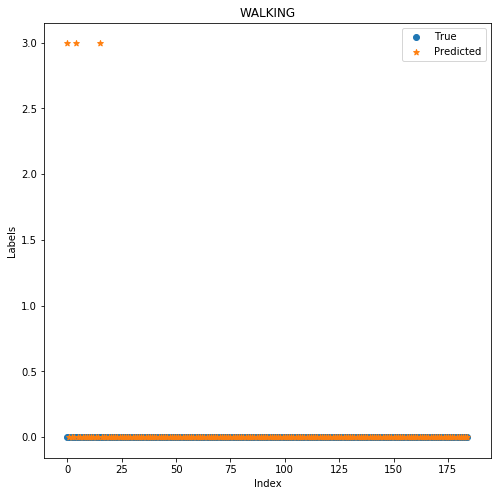

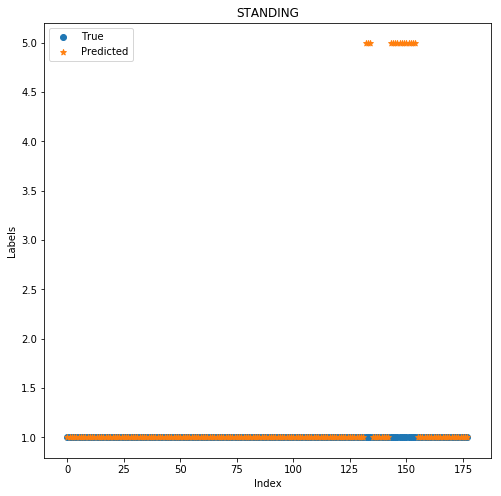

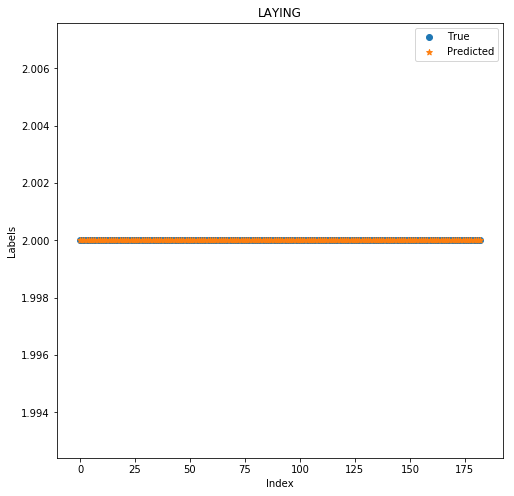

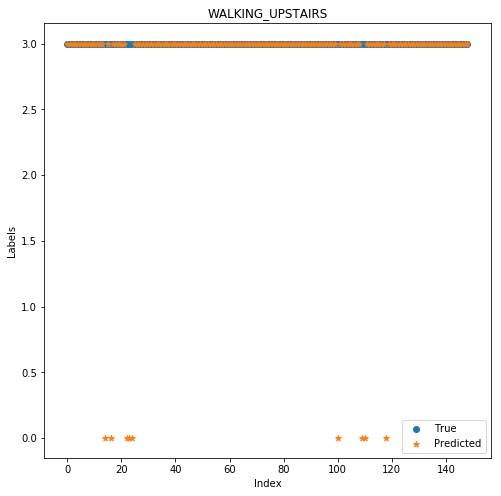

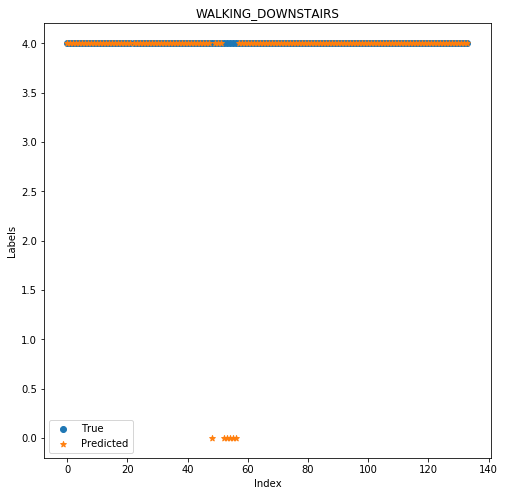

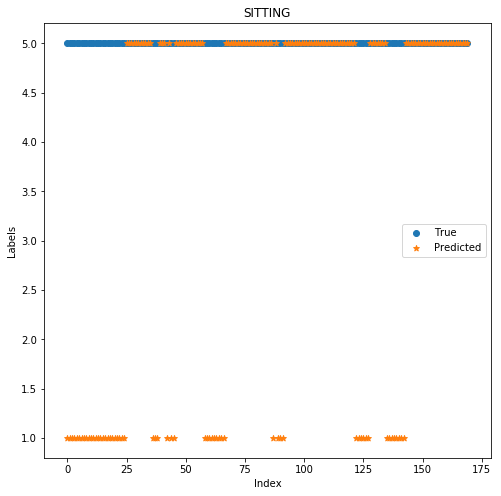

In [0]:
#Plotting output True vs Predictions for best model i.e random forest: FOR EACH CLASS .
y_pred_rf = rf_random.predict(X_test_small)
for i in range(6):
    plt.figure(figsize=(8,8))
    y_test_curr = y_test.loc[y_test==i]
    y_pred_curr = y_pred_rf[y_test_curr.index]
    plt.scatter(range(len(y_test_curr)) , y_test_curr, label='True')
    plt.scatter(range(len(y_pred_curr)) , y_pred_curr , marker='*', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel('Labels')
    plt.legend()
    plt.title(list(label_encoding.keys())[i])
    plt.show()